Epoch 1/50
393/393 [==============================] - 0s 753us/step - loss: 0.1294 - acc: 0.9689 - val_loss: 0.1489 - val_acc: 0.9661 - lr: 0.0010
Epoch 2/50
393/393 [==============================] - 0s 583us/step - loss: 0.1225 - acc: 0.9708 - val_loss: 0.1439 - val_acc: 0.9678 - lr: 0.0010
Epoch 3/50
393/393 [==============================] - 0s 575us/step - loss: 0.1203 - acc: 0.9712 - val_loss: 0.1429 - val_acc: 0.9678 - lr: 0.0010
Epoch 4/50
393/393 [==============================] - 0s 578us/step - loss: 0.1191 - acc: 0.9709 - val_loss: 0.1420 - val_acc: 0.9678 - lr: 0.0010
Epoch 5/50
393/393 [==============================] - 0s 581us/step - loss: 0.1182 - acc: 0.9709 - val_loss: 0.1383 - val_acc: 0.9678 - lr: 0.0010
Epoch 6/50
393/393 [==============================] - 0s 582us/step - loss: 0.1171 - acc: 0.9714 - val_loss: 0.1384 - val_acc: 0.9678 - lr: 0.0010
Epoch 7/50
393/393 [==============================] - 0s 583us/step - loss: 0.1163 - acc: 0.9710 - val_loss: 0.1392 - 

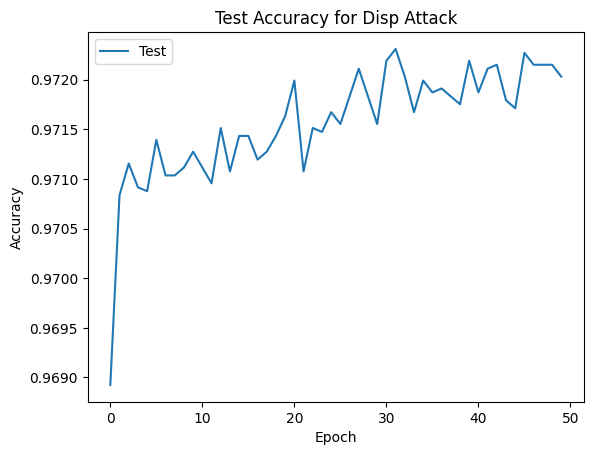

Test Accuracy: 97.58%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
import pandas as pd
import numpy as np
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
import tensorflow as tf

original_model = load_model('my_malconv_model.h5')

file_path = '/Users/pratiktale/Research Project/dataset_malwares.csv'
df = pd.read_csv(file_path)

selected_features = df[["MinorOperatingSystemVersion", "MajorSubsystemVersion", 
                        "SizeOfStackReserve", "MajorLinkerVersion", 
                        "MajorOperatingSystemVersion", "MinorImageVersion", 
                        "Subsystem", "MinorSubsystemVersion"]]
labels = df["Malware"]

X_train, X_test, y_train, y_test = train_test_split(selected_features, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

max_size = len(selected_features.columns)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, max_size))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, max_size))

def pgd(model, X, y, epsilon=0.001, alpha=0.0002, num_iter=500):
    X_adv = tf.identity(X)
    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(X_adv)
            prediction = model(X_adv)
            loss = tf.keras.losses.binary_crossentropy(y, prediction)
        gradient = tape.gradient(loss, X_adv)
        signed_grad = tf.sign(gradient)
        X_adv = X_adv + alpha * signed_grad
        X_adv = tf.clip_by_value(X_adv, X - epsilon, X + epsilon)
        X_adv = tf.clip_by_value(X_adv, 0, 1)
    return X_adv.numpy()

y_train_array = np.array(y_train).reshape(-1, 1)
X_train_pgd = pgd(original_model, X_train_scaled, y_train_array)

X_combined = np.concatenate((X_train_scaled, X_train_pgd))
y_combined = np.concatenate((y_train_array, y_train_array))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = original_model.fit(X_combined, y_combined, batch_size=64, epochs=50, validation_split=0.2, callbacks=[reduce_lr, early_stopping])

plt.plot(history.history['acc'], label='Test')
plt.title('Test Accuracy for Disp Attack')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

test_loss, test_accuracy = original_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

original_model.save('my_updated_Disp_malconv_model.h5')

